## Assignment 5: Exploring Clustering & Anomaly Detection Using `scikit-learn` & `scipy`

In this assignment you will explore the fascinating concepts of clustering and anomaly detection using Python's `scikit-learn` and `scipy` libraries.

In [1]:
# YOUR NAME(S) GO HERE
#Peijie Yang (py2554); Pengdi Xia (px353)
#late day usage: 1


In [2]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import random as rand
import itertools as it

from pandas import DataFrame, Series

from scipy.cluster import hierarchy as hier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import StratifiedKFold

In [3]:
%matplotlib inline

### Part 1: Clustering

For the first part of the assigment you'll be working with the Epileptic Seizure Recognition Data Set developed at Rochester Institute of Technology. In this data set each row is a sample of the EEG recording at a different point in time. The dataset contains 179 columns, the first 178 are the EEG features while the last column represents the label y {1, 2, 3, 4, 5}. All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. The only change that was made to the original dataset was removing the first column, which contained the row indexes. You can find additional information about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition).

In [4]:
# Reading the Epileptic Seizure Data Set
dataset = pd.read_csv("seizure_edited.csv", header = 0)
print(dataset.shape)
labels = dataset['y']
data = dataset.drop('y', axis = 1)
dataset.head(10)
dataset_origin = dataset
dataset2 = dataset


(11500, 179)


This provided function uses `sklearn.manifold.MDS` to project the data onto 2 dimensions for plotting. It randomly samples 100 rows from the dataset, runs MDS on this sample, and plots it on a 2D scatter plot with appropriate colors based on their labels. 

In [5]:
def scatter(data, labels, numPoints = 100):
    mds = MDS(n_components=2)
    
    numEntries = data.shape[0]
    start = rand.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds_data = mds.fit_transform(data.iloc[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

Q1. Reduce the dimensionality of the dataset with PCA. Remember to scale the data prior to running it through PCA. Reduce the number of dimensions by keeping only the first 95% of the explained variance. Print the shape of the new dataset to show its number of dimensions. Plot the dataset using the provided `scatter` function. Verify that the plot looks like 2 clusters, an inner cluster (non-seizure patients, labels 2-5) and outer cluster (seizure patients, label 1). 

39


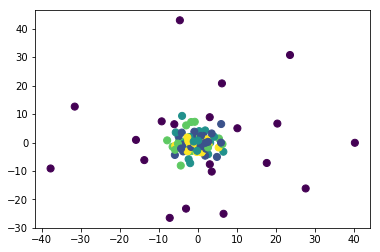

In [6]:
# your code goes here
data_standard = sk.preprocessing.StandardScaler().fit(data).transform(data)
pca = PCA()
pca.fit(data_standard)
cumsum = np.cumsum(pca.explained_variance_ratio_)
n = np.argmax(cumsum >= 0.95) + 1
print(n)

pca = PCA(n_components = n )
data_reduce = pca.fit_transform(data_standard)
# change the type
df_reduce = DataFrame(data_reduce)
scatter(df_reduce,labels)
data = df_reduce
data_origin = df_reduce

**Only** for questions Q2, Q3 and Q4 on hierarchical clustering you'll work with sample of ~100 datapoints.

In [7]:
# stratified sampling of the data
aggloData = None
aggloLabels = None

kfold = StratifiedKFold(n_splits = 100, shuffle = True)
for throwAway_index, subsample_index in kfold.split(data, labels):
    aggloData = data.iloc[subsample_index]
    aggloLabels = labels.iloc[subsample_index]
    
    break
print(aggloData.shape)

(115, 39)


Q2. Use `scipy`'s hierarchical clustering to cluster the data using different linkage methods. Look at the CPCC of each method to determine which method worked best. You need to atleast test these linkage methods - [`single`, `complete`, `average`, `centroid`, `ward`].

In [8]:
# your code goes here
from scipy.cluster.hierarchy import dendrogram, linkage
method_name = ["single", "complete", "average", "centroid", "ward"]
for i in method_name:
    data_single = linkage(aggloData,method=i,metric='euclidean')
    y = pdist(aggloData)
    c = hier.cophenet(data_single,y)
    print(i+ " method has CPCC of: "+str(c[0]))
#cor_list = np.corrcoef(data_single_1d,aggloData_1d)
#print("so the CPCC is: " + str(cor_list[0][1]))
#print(len(data_single_1d[0]))
#data_complete = linkage(dataset,method='complete',metric='euclidean')
#data_average = linkage(dataset,method='average',metric='euclidean')
#data_centroid = linkage(dataset,method='centroid',metric='euclidean')
#data_ward = linkage(dataset,method='ward',metric='euclidean')
# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib import pyplot as plt
# X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
# Z = linkage(X, 'ward')
# Z = linkage(X, 'single')
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)
# plt.show()

single method has CPCC of: 0.989975346159
complete method has CPCC of: 0.973651952053
average method has CPCC of: 0.992073919
centroid method has CPCC of: 0.991818263983
ward method has CPCC of: 0.944105590874


Q3. Using the best linkage method that you found in Q2, plot the dendrogram (`scipy.cluster.hierarchy.dendrogram`). 

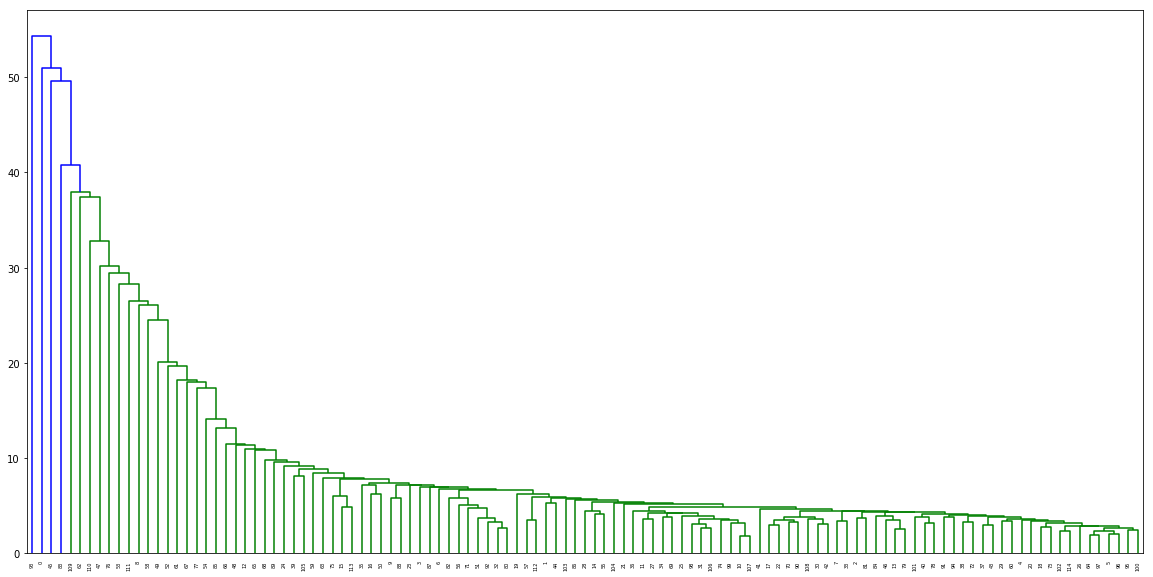

In [9]:
# your code goes here
data_average = linkage(aggloData,method='average',metric='euclidean')
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(data_average)

Q4. Find the optimal number of clusters according to the hierarchical clustering, using the best linkage method you found in Q2.

`scipy.cluster.hierarchy.linkage` gives the hierarchical clustering encoded as a linkage matrix. The method returns a `(n-1)` by `4` linkage matrix `Z` (where `n` is the total number of points). At the i-th iteration, clusters with indices `Z[i, 0]` and `Z[i, 1]` are combined to form cluster `n+i`. A cluster with an index less than `n` corresponds to one of the original observations. The distance between clusters `Z[i, 0]` and `Z[i, 1]` is given by `Z[i, 2]`. The fourth value, `Z[i, 3]` represents the number of original observations in the newly formed cluster.

You need to compute the maximum difference between `Z[i, 2]` and `Z[i+1, 2]` and use that to calculate the optimal number of clusters for the best linkage method you found in Q2.

In [10]:
# your code goes here
data_list = []
difference = 0
index_x = 0
for x in range(len(data_average)-1):
    if difference < abs(data_average[x,2]-data_average[x+1,2]):
        difference = abs(data_average[x,2]-data_average[x+1,2])
        index_x = x
k = len(data_average) - index_x 
print("Therefore, maximum difference is "+str(difference) + ", and optimal number of clusters is " + str(k))

Therefore, maximum difference is 8.81464393494, and optimal number of clusters is 4


Q5. Run K-means clustering on the full dataset with the optimal cluster count provided by the agglomerative evaluation in Q4. Print the silhouette score for the clusters and compare this to the silhouette scores for K-means clustering  using k = 2 and 5.  

In [11]:
# your code goes here
KMeans_result_7 = KMeans(n_clusters = 4).fit(data_origin)
KMeans_label_7 = KMeans_result_7.labels_
score_7 = silhouette_score(data_origin,KMeans_label_7)

KMeans_result_5 = KMeans(n_clusters = 5).fit(data_origin)
KMeans_label_5 = KMeans_result_5.labels_
score_5 = silhouette_score(data_origin,KMeans_label_5)

KMeans_result_2 = KMeans(n_clusters = 2).fit(data_origin)
KMeans_label_2 = KMeans_result_2.labels_
score_2 = silhouette_score(data_origin,KMeans_label_2)

print("silhouette score for k = 4 is " + str(score_7))
print("silhouette score for k = 5 is " + str(score_5))
print("silhouette score for k = 2 is " + str(score_2))

silhouette score for k = 4 is 0.074646727369
silhouette score for k = 5 is 0.085827751696
silhouette score for k = 2 is 0.0734603261832


Q6. Use the provided `scatter` function to plot the results of K-means clustering with k = 2. Evaluate the accuracy of this custering against the true labels. 
NOTE:- You'll need to relabel y = {2, 3, 4, 5} to label 0 in the ground truth labels.

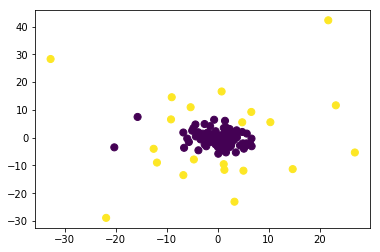

the accuracy is 0.4071304347826087


In [12]:
# your code goes here

y = {2,3,4,5}
for i in range(len(data_origin)):
    if (labels[i] in y):
        labels[i] = 0

KMeans_result = KMeans(n_clusters = 2).fit(data_origin)
KMeans_label = KMeans_result.labels_
correct = 0
temp = labels
for x in range(len(labels)):
    if (KMeans_label[x] == labels[x]):
        correct += 1
        temp[x] = KMeans_label[x]
scatter(data_origin, temp)
print ("the accuracy is " + str(correct/len(KMeans_label)))


In questions Q8 and Q7 you'll cluster the data using DBSCAN.

Q7. Find the optimal eps by plotting the distances to the 4th nearest neighbor (`sklearn.neighbors.NearestNeighbors`) & identify the bend in the graph.

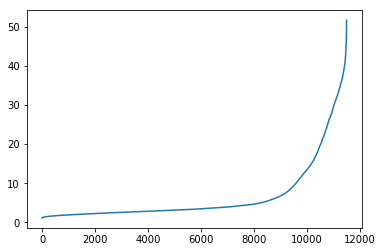

In [13]:
# your code goes here
nearestNeighbor = NearestNeighbors(n_neighbors = 4).fit(data_origin)
a, b = nearestNeighbor.kneighbors(data_origin,return_distance=True)
sample_list = []
for x in a: 
    sample_list.append(x[3])
sample_list.sort()
plt.plot(sample_list)

Q8. Use MinPts=4 and Eps=the distance at the bend (your best estimate by looking at the graph in Q7), cluster the data using DBSCAN. Use the provided `scatter` function to plot the result of the clustering.

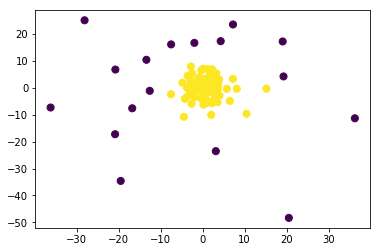

In [14]:
# your code goes here
DBSCAN_result = DBSCAN(eps = 9, min_samples = 4).fit(data_origin)
DB_label = DBSCAN_result.labels_
for x in range(len(labels)):
    labels [x] = DB_label[x]
scatter(data_origin, labels)

Q9. The data points in the seizure class (label = 1) are more sparse, so DBSCAN will label them as noise (-1). Convert these noise points to label 1 and evaluate the accuracy against the true labels.
NOTE:- You'll also need to relabel y = {2, 3, 4, 5} to label 0 in the ground truth labels.

In [15]:
# your code goes here
DB_label = DBSCAN_result.labels_
for x in range(len(DB_label)): 
    if (DB_label[x] == -1):
        DB_label[x] = 1
correct = 0
for x in range(len(DB_label)):
    if (DB_label[x] == labels[x]):
        correct += 1
print ("the accuracy is " + str(correct/len(DB_label)))

the accuracy is 0.8317391304347826


### Part 2: Anomaly Detection

In most real life applications the data observations are subject to noise present either in the environment or the sensor apparatus. Anomaly detection (AD) plays a vital role in the preprocessing stage to identify these outliers and remove them from the training set. Anomaly detection algorithms can be broadly classified into 3 classes (see Nicolas Goix's [slides](https://ngoix.github.io/nicolas_goix_osi_presentation.pdf) on anomaly detection):-
- Supervised AD (labels available for both normal data and anomalies)
- Semi-supervised AD, also called Novely Detection (only normal data available to train)
- Unsupervised AD, also called Outlier Detection (no labels are provided)

In this section you'll experiment with 4 datasets and compare 4 different outlier detection (Unsupervised AD) methods.

In [16]:
from IPython.display import Image
Image("scatters.png")

# loading the datasets
filenames = ['data1.csv', 'data2.csv', 'data3.csv', 'data4.csv']
datasets = [np.loadtxt(fname, delimiter=', ') for fname in filenames]
for fname, data in zip(filenames, datasets):
    print (fname, data.shape)

data1.csv (445, 2)
data2.csv (314, 2)
data3.csv (419, 2)
data4.csv (441, 2)


Q10. Detect the outliers in all 4 datasets using the following algorithms:-
- `sklearn.covariance.EllipticEnvelope` - a statistical-based AD method
- `sklearn.ensemble.IsolationForest` - an isolation-based AD method
- `sklearn.neighbors.LocalOutlierFactor` - a density-based AD method
- `sklearn.svm.OneClassSVM` - a model-based AD method

Create scatterplots that show the outliers detected in each dataset with each method. (16 plots in total.)
For example:
![title](scatters.png)

Directions:
* For the `OneClassSVM` use `rbf` kernel.
* Use a `contamination` (or `nu` for `OneClassSVM`) of 0.25. 

NOTE: To preform AD in an unsupervised way, you will pass the same dataset into `fit` and `predict.`

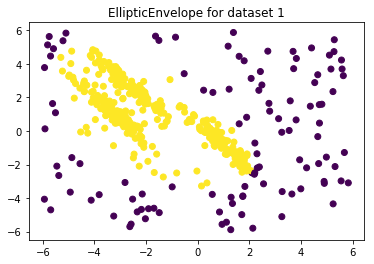

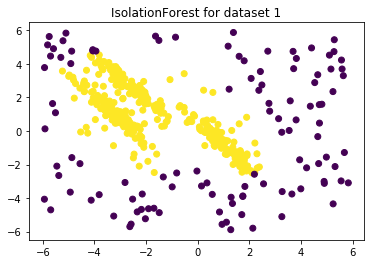

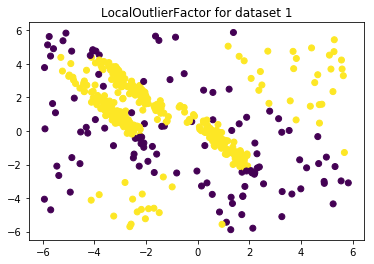

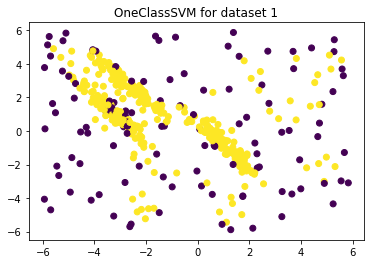

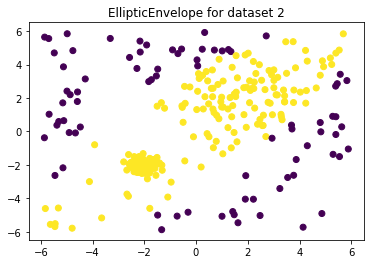

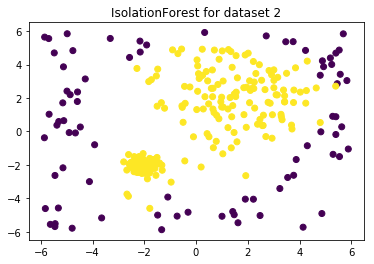

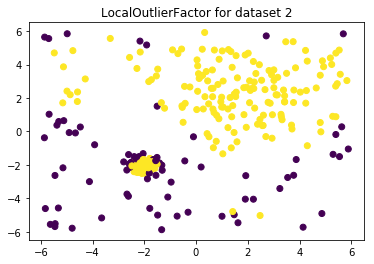

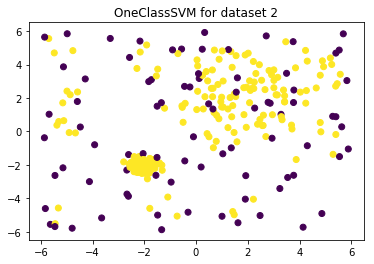

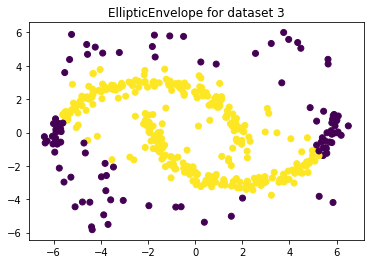

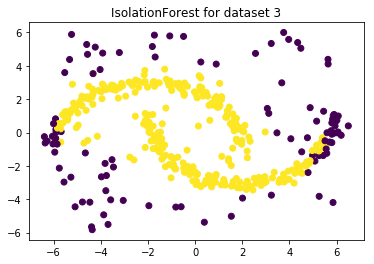

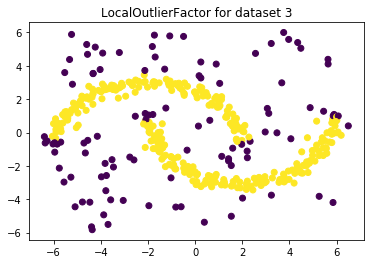

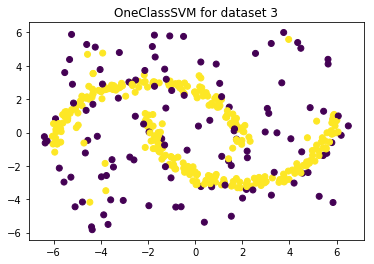

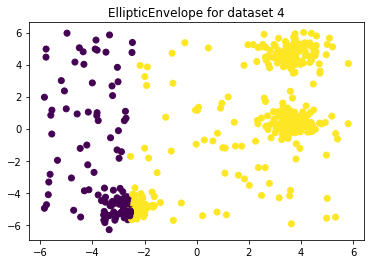

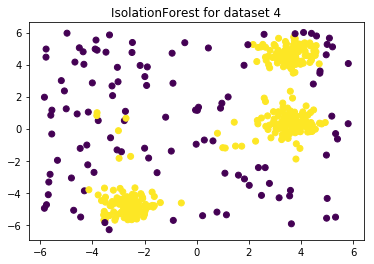

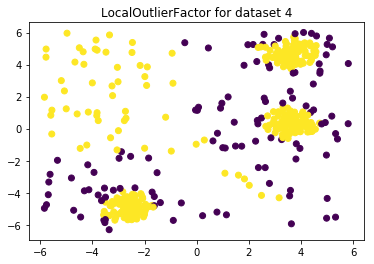

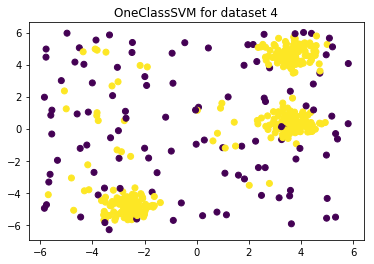

In [17]:
# your code goes here
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
count = 0
for x in datasets: 
    count+=1
    EllipticEnvelope_ = EllipticEnvelope(contamination = 0.25)
    EllipticEnvelope_.fit(x)
    EllipticEnvelope_predict = EllipticEnvelope_.predict(x)
    plt.scatter(x[:, 0], x[:, 1], c = EllipticEnvelope_predict)
    plt.title('EllipticEnvelope for dataset ' + str(count))
    plt.show()
    IsolationForest_ = IsolationForest(contamination = 0.25)
    IsolationForest_.fit(x)
    IsolationForest_predict = IsolationForest_.predict(x)
    plt.scatter(x[:, 0], x[:, 1], c=IsolationForest_predict)
    plt.title('IsolationForest for dataset ' + str(count))
    plt.show()
    LocalOutlierFactor_ = LocalOutlierFactor(contamination= 0.25)
    LocalOutlierFactor_.fit(x)
    LocalOutlierFactor_predict = LocalOutlierFactor_.fit_predict(x)
    plt.scatter(x[:, 0], x[:, 1], c = LocalOutlierFactor_predict)
    plt.title('LocalOutlierFactor for dataset ' + str(count))
    plt.show()
    OneClassSVM_ = OneClassSVM(nu = 0.25, kernel= "rbf")
    OneClassSVM_.fit(x)
    OneClassSVM_predict = OneClassSVM_.predict(x)
    plt.scatter(x[:, 0], x[:, 1], c = OneClassSVM_predict)
    plt.title('OneClassSVM for dataset ' + str(count))
    plt.show()
    